In [1]:
import pandas as pd
import numpy as np
from dataloading import DataLoader
from eda_py import EDA
from eALS_adaptor import eALSAdaptor
from implicit.evaluation import train_test_split, ranking_metrics_at_k
from cv_py import CrossValidation
from visualize_py import Visualize
from lightFM_adoptor import LightFMAdaptor
from datapreparation_py import DataPreparation
from scipy import sparse

%cd C:\Users\781110104\OneDrive - Genpact\Documents\VSCode

C:\Users\781110104\OneDrive - Genpact\Documents\VSCode


c:\Users\781110104\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
dl = DataLoader()
user_item_co = dl.import_data('AGCO', 'CO', 'df')

In [3]:
user_item_co_filtered = dl.remove_low_interact_items(user_item_co, 1)
user_item_filtered_log_t = dl.log_scale_df(user_item_co_filtered, 0.01)

In [4]:
dp = DataPreparation(user_item_filtered_log_t)

In [4]:
items = pd.read_csv('items_agco_new.csv', sep='|', low_memory=False)

In [5]:
skus = pd.read_csv('skus_agco_new.csv', sep='|', low_memory=False)

In [5]:
interactions_csr, weights_csr = dp.get_interaction_data()

In [8]:
user_features = ['country', 'brand', 'currency', 'dealer_size']
item_features = ['group2', 'movement_code', 'cost_class', 'cps_category']   
return_list = dp.get_feature_data(OEM='AGCO', user_features=user_features, item_features=item_features)

In [9]:
userf, itemf = return_list

In [29]:
sparse.save_npz('user_feature_matrix_agco.npz', userf)

In [33]:
sparse.save_npz('item_feature_matrix_agco.npz', itemf)

In [30]:
userf

<303x330 sparse matrix of type '<class 'numpy.float32'>'
	with 649 stored elements in Compressed Sparse Row format>

In [6]:
loaded_userf = sparse.load_npz('user_feature_matrix_agco.npz')

In [7]:
loaded_itemf = sparse.load_npz('item_feature_matrix_agco.npz')

In [35]:
loaded_itemf

<202000x202415 sparse matrix of type '<class 'numpy.float32'>'
	with 489905 stored elements in Compressed Sparse Row format>

In [8]:
train_i, test_i = train_test_split(interactions_csr, 0.8, 22)
train_w, test_w = train_test_split(weights_csr, 0.8, 22)

In [ ]:
model_adapt = LightFMAdaptor(loss='warp', random_state=22, no_components=64, iterations=15, item_alpha=0.001, user_alpha=0.001, learning_rate=0.005)

In [9]:
model_adapt = LightFMAdaptor(loss='warp', random_state=22)

In [10]:
model_adapt.fit(interactions=train_i, user_features=loaded_userf, item_features=loaded_itemf, weights=train_w, show_progress=True, transform_factors=False)

Epoch: 100%|██████████| 1/1 [00:13<00:00, 13.14s/it]


In [11]:
pk = model_adapt.evaluate(test_interactions=test_i, train_interactions=train_i, user_features=loaded_userf, item_features=loaded_itemf, k=10)
pk

0.57326734

In [69]:
results = []
for r in [0.00001, 0.00007, 0.0001, 0.0003, 0.001, 0.01]: # regularization
    for lr in [0.001, 0.01, 0.05, 0.07, 0.1, 0.3, 0.5]: # learning rate
        model = LightFMAdaptor(loss='bpr', random_state=22, no_components=32, iterations=5, item_alpha=r, user_alpha=r, learning_rate=lr)
        model.fit(interactions=train_i, user_features=loaded_userf, item_features=loaded_itemf, weights=train_w, show_progress=True, transform_factors=False)
        pk = model.evaluate(test_interactions=test_i, train_interactions=train_i, user_features=loaded_userf, item_features=loaded_itemf, k=10)
        res = {'reg': r, 'lr' : lr, 'ms' : ms, 'p@k' : pk}
        results.append(res)


Epoch: 100%|██████████| 5/5 [02:07<00:00, 25.56s/it]


In [70]:
for i in range(len(results)):
    if i == 0:
        result_df_bpr = pd.DataFrame(results[0], index=[0])
    else:
        result_df_bpr = pd.concat([result_df_bpr, pd.DataFrame(results[i], index=[i])])


In [54]:
for i in range(len(results)):
    result_df = pd.concat([result_df, pd.DataFrame(results[i], index=[i])])

In [55]:
result_df.sort_values('p@k', ascending=False)

,reg,lr,ms,p@k
0,0.00010,0.100,30,0.779868
13,0.00010,0.100,30,0.779868
11,0.00010,0.070,35,0.776238
9,0.00010,0.070,25,0.768317
8,0.00010,0.050,30,0.764356
7,0.00010,0.050,20,0.763036
0,0.00010,0.050,40,0.763036
20,0.00030,0.070,35,0.760396
2,0.00007,0.070,35,0.759076
4,0.00007,0.100,30,0.759076


In [68]:
result_df[['ms']].drop_duplicates().sort_values('ms')

,ms
3,10
1,20
0,25
0,30
2,35
0,40


In [71]:
result_df_bpr.sort_values('p@k', ascending=False)

,reg,lr,ms,p@k
9,0.00007,0.050,35,0.409571
16,0.00010,0.050,35,0.390429
10,0.00007,0.070,35,0.357096
0,0.00001,0.001,35,0.343564
7,0.00007,0.001,35,0.341914
14,0.00010,0.001,35,0.340924
21,0.00030,0.001,35,0.336964
2,0.00001,0.050,35,0.333333
1,0.00001,0.010,35,0.329043
8,0.00007,0.010,35,0.298020


In [18]:
from implicit.evaluation import ranking_metrics_at_k

In [19]:
ranking_metrics_at_k(model_adapt, train_w, test_w, 10)

  0%|          | 0/303 [00:00<?, ?it/s]

{'precision': 0.5732673267326732,
 'map': 0.46093037875216075,
 'ndcg': 0.5909468719658185,
 'auc': 0.5025406698625545}

In [20]:
from lightfm import LightFM

In [21]:
model_orig = LightFM(loss='warp', random_state=22)

In [24]:
model_orig.fit(interactions=train_i, user_features=userf, item_features=itemf, sample_weight=train_w.tocoo(), verbose=True)

Epoch: 100%|██████████| 1/1 [00:12<00:00, 12.33s/it]


In [25]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank

In [26]:
pk = precision_at_k(model=model_orig, test_interactions=test_i, train_interactions=train_i, user_features=userf, item_features=itemf).mean()
pk

0.57326734

In [46]:
available_items = user_item_filtered_log_t[['item']].drop_duplicates()
items_filtered = pd.merge(available_items, items, left_on='item', right_on='item_id', how='left')

In [47]:
skus.head()

,location_id,item_id,cost_class,movement_code,comparative_planning_score,comparative_planning_score_percentile
0,AGWOOD_02,0-110-7500-00,low,non_moving,0.0000,0.110318
1,LISTER_WILDER_POOLING,0-113-7505-00,very_low,non_moving,5.8333,0.923979
2,REDLYNCH_01,0-113-7505-00,very_low,non_moving,5.8333,0.923979
3,REDLYNCH_02,0-113-7505-00,very_low,non_moving,5.8333,0.923979
4,REDLYNCH_POOLING,0-113-7505-00,very_low,non_moving,5.8333,0.923979


In [49]:
skus_mapped = map_cps(skus)

In [50]:
skus_mapped.head()

,location_id,item_id,cost_class,movement_code,comparative_planning_score,comparative_planning_score_percentile,cps_category
0,AGWOOD_02,0-110-7500-00,low,non_moving,0.0000,0.110318,1
1,LISTER_WILDER_POOLING,0-113-7505-00,very_low,non_moving,5.8333,0.923979,2
2,REDLYNCH_01,0-113-7505-00,very_low,non_moving,5.8333,0.923979,2
3,REDLYNCH_02,0-113-7505-00,very_low,non_moving,5.8333,0.923979,2
4,REDLYNCH_POOLING,0-113-7505-00,very_low,non_moving,5.8333,0.923979,2


<AxesSubplot:>

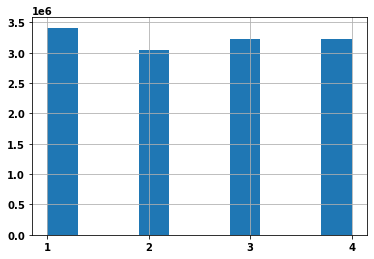

In [51]:
skus_mapped.cps_category.hist()

In [52]:
item_sku_features = pd.merge(items_filtered, skus_mapped, on='item_id', how='left')

In [84]:
uif_temp = item_sku_features[item_sku_features.item == '0.012.2614.3'][['item', 'cost_class']].dropna().set_index('item')

In [85]:
uif_temp.head()

,cost_class
item,
0.012.2614.3,medium
0.012.2614.3,medium
0.012.2614.3,medium
0.012.2614.3,medium
0.012.2614.3,medium


In [86]:
ui_features = dp._gather_features(uif_temp)
ui_tuple = dp._get_feature_tuple(uif_temp)

In [87]:
ui_tuple

[('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012.2614.3', ['medium']),
 ('0.012

In [88]:
from lightfm.data import Dataset
dataset_t = Dataset()

In [89]:
dataset_t.fit(np.array(['user']), np.array(['0.012.2614.3']), item_features = ui_features)
ui_features_sp = dataset_t.build_item_features(ui_tuple, normalize=False)

In [90]:
ui_features_sp.todense()

matrix([[ 1., 68.,  2.]], dtype=float32)

In [91]:
ui_features_sp_norm = dp._normalize(ui_features_sp)

In [92]:
ui_features_sp_norm.todense()

matrix([[1.        , 0.9714286 , 0.02857143]], dtype=float32)

In [68]:
item_sku_features[item_sku_features.item == '0.012.2614.3'].shape

(95, 9)

In [29]:
col = user_features.item_count
bins = [col.min(), np.percentile(col, 25), np.percentile(col, 50), np.percentile(col, 75), col.max()]
names = ['1', '2', '3', '4']

In [30]:
user_features['dealer_size'] = pd.cut(user_features['item_count'], bins=bins, labels=names)

In [31]:
user_features.head()

,location_id,dealer,country,item_count,currency,brand,dealer_size
0,ACA_01,ACA,Austria,21743.0,EUR,0,4
1,ACA_02,ACA,Austria,18277.0,EUR,MOTIONDATA,4
2,ACA_03,ACA,Austria,12753.0,EUR,MOTIONDATA,3
3,ACA_04,ACA,Austria,13701.0,EUR,MOTIONDATA,4
4,ACA_05,ACA,Austria,27508.0,EUR,MOTIONDATA,4


<AxesSubplot:>

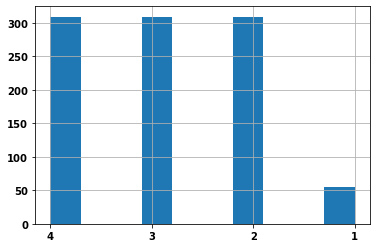

In [33]:
user_features.dealer_size.hist()

In [39]:
def map_dealer_size(user_features):
    user_features_temp = user_features.copy()
    user_features_temp['item_count'] = user_features_temp.item_count.fillna(0)
    col = user_features_temp.item_count
    bins = [col.min(), np.percentile(col, 25), np.percentile(col, 50), np.percentile(col, 75), col.max()]
    names = ['1', '2', '3', '4']
    user_features_temp['dealer_size'] = pd.cut(user_features_temp['item_count'], bins=bins, labels=names)
    return user_features_temp

In [48]:
def map_cps(skus):
    skus_temp = skus.copy()
    skus_temp['comparative_planning_score'] = skus_temp.comparative_planning_score.fillna(0)
    col = skus_temp.comparative_planning_score
    bins = [col.min(), np.percentile(col, 25), np.percentile(col, 50), np.percentile(col, 75), col.max()]
    names = ['1', '2', '3', '4']
    skus_temp['cps_category'] = pd.cut(skus_temp['comparative_planning_score'], bins=bins, labels=names)
    return skus_temp